In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.stats import spearmanr, mannwhitneyu

sns.set_theme(style="whitegrid", font_scale=1.1)

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df).dropna(subset=['rating'])


In [ ]:
# emotional engagement items (Likert 1–5)
emotion_items = mdf.get_movie_experience_names(df)
emotion_items = [mdf.clean_column_name(item) for item in emotion_items]


# compute emotional engagement index (mean of 10 items per viewer)
emotion_scores = (
    processed_data[['report_id'] + emotion_items]
    .drop_duplicates(subset='report_id')
    .set_index('report_id')
)
emotion_scores['emotion_mean'] = emotion_scores[emotion_items].mean(axis=1)

# compute variance in ratings per viewer (rating variability)
rating_var = (
    processed_data.groupby('report_id')['rating']
    .var()
    .rename('rating_var')
)

# merge emotion scores and rating variability
viewer_data = pd.concat([emotion_scores['emotion_mean'], rating_var], axis=1).dropna()

# spearman correlation test
rho, pval = spearmanr(viewer_data['emotion_mean'], viewer_data['rating_var'])
print(f"Spearman correlation: rho={rho:.3f}, p={pval:.3e}")

# 5. Mann–Whitney U test (median split)
median_emotion = viewer_data['emotion_mean'].median()
low = viewer_data.loc[viewer_data['emotion_mean'] <= median_emotion, 'rating_var']
high = viewer_data.loc[viewer_data['emotion_mean'] > median_emotion, 'rating_var']

U, p = mannwhitneyu(low, high, alternative='two-sided')
print(f"Mann–Whitney U test: U={U:.2f}, p={p:.3e}")
print(f"Mean variability (low): {low.mean():.3f}, Mean variability (high): {high.mean():.3f}")



Spearman correlation: rho=-0.014, p=6.385e-01
Mann–Whitney U test: U=142685.50, p=5.612e-01
Mean variability (low): 0.761, Mean variability (high): 0.776


/var/folders/9t/kz_xx0px1mxf1wqtzvvb57fc0000gn/T/ipykernel_83908/2492117985.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


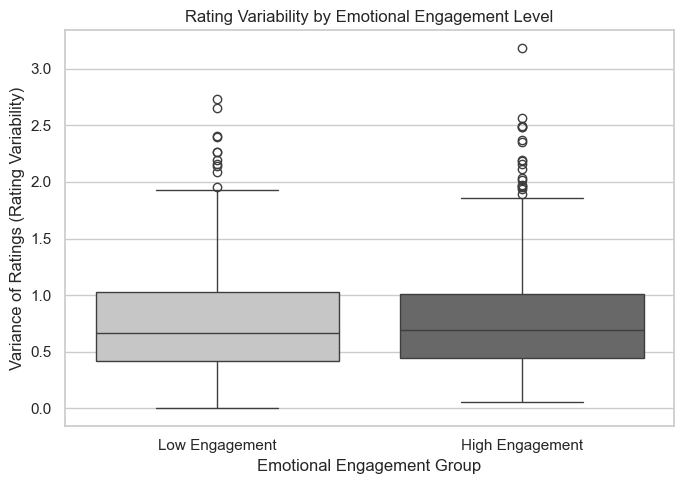

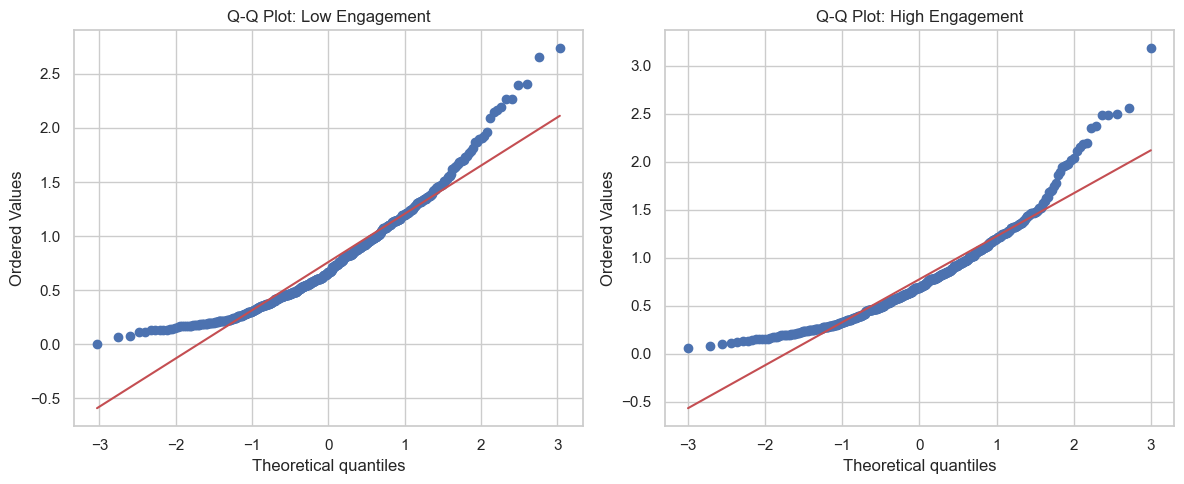

In [ ]:

# 6. Visualization — Rating Variability by Emotional Engagement
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
sns.boxplot(
    x=['Low Engagement'] * len(low) + ['High Engagement'] * len(high),
    y=pd.concat([low, high]),
    palette='Greys'
)
plt.title('Rating Variability by Emotional Engagement Level')
plt.ylabel('Variance of Ratings (Rating Variability)')
plt.xlabel('Emotional Engagement Group')
plt.tight_layout()
plt.savefig('../figures/rating_variability_emotion.pdf', dpi=300)
plt.show()

# qq-plot for normality check for each group
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
stats.probplot(low, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot: Low Engagement')
stats.probplot(high, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: High Engagement')
plt.tight_layout()

Text(0.5, 1.0, 'Distribution of Extreme Movie Ratings by Immersion Level')

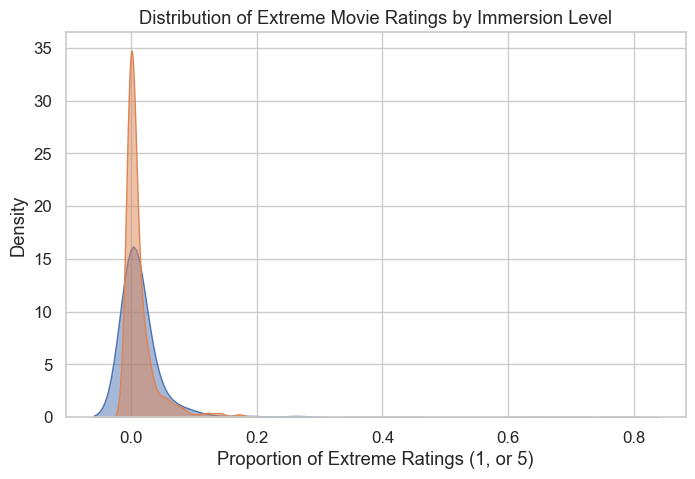

In [29]:
# plot the distbutions 

plt.figure(figsize=(8, 5))
sns.kdeplot(low, label='Low Immersion', fill=True, alpha=0.5)
sns.kdeplot(high, label='High Immersion', fill=True, alpha=0.5)
plt.xlabel('Proportion of Extreme Ratings (1, or 5)')
plt.title('Distribution of Extreme Movie Ratings by Immersion Level')